In [32]:
# import nessesary modules
import tensorflow as tf
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle

In [33]:
DATA_PATH='datasets'
CLASSES=os.listdir(DATA_PATH)
CLASSES.sort()
# IMG_WIDTH=640
# IMG_HEIGHT=480
IMG_WIDTH=300
IMG_HEIGHT=300
RGB=3
NUM_CLASSES=len(CLASSES)
EPOCHS=9

In [34]:
data=tf.keras.utils.image_dataset_from_directory(DATA_PATH,
                                                 image_size=(IMG_WIDTH,IMG_HEIGHT))

Found 800 files belonging to 4 classes.


In [35]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(IMG_HEIGHT, 
                                                              IMG_WIDTH,
                                                              RGB)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    #tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
])

In [36]:
data=data.map(lambda x,y: (x/255,y))

In [37]:
train_size = int(len(data)*0.8)
val_size = int(len(data)*0.1)
test_size = int(len(data)*0.1)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [38]:
model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3,3),1, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(32, (4,4),1, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(16, (3,3),1, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')    
])

In [39]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
               loss=tf.losses.SparseCategoricalCrossentropy(), 
               metrics=['accuracy']
               )

In [40]:
if os.path.isfile('model.h5'):
    model=tf.keras.models.load_model('model.h5')
    with open('trainHistoryDict', "rb") as file:
        hist = pickle.load(file)

else:
    history=model.fit(train, epochs=EPOCHS,validation_data=val)    
    model.save('model.h5')
    hist=history.history
    with open('trainHistoryDict', 'wb') as file:
        pickle.dump(hist, file)

Epoch 1/9


20/20 [==============================] - 28s 1s/step - loss: 1.3497 - accuracy: 0.2969 - val_loss: 1.2964 - val_accuracy: 0.4688
Epoch 2/9
20/20 [==============================] - 26s 1s/step - loss: 1.1320 - accuracy: 0.5984 - val_loss: 0.9874 - val_accuracy: 0.6875
Epoch 3/9
20/20 [==============================] - 25s 1s/step - loss: 0.8264 - accuracy: 0.7641 - val_loss: 0.7182 - val_accuracy: 0.7188
Epoch 4/9
20/20 [==============================] - 25s 1s/step - loss: 0.5803 - accuracy: 0.7703 - val_loss: 0.5880 - val_accuracy: 0.6719
Epoch 5/9
20/20 [==============================] - 25s 1s/step - loss: 0.4381 - accuracy: 0.8500 - val_loss: 1.1549 - val_accuracy: 0.6250
Epoch 6/9
20/20 [==============================] - 25s 1s/step - loss: 0.3711 - accuracy: 0.8641 - val_loss: 0.3432 - val_accuracy: 0.8594
Epoch 7/9
20/20 [==============================] - 24s 1s/step - loss: 0.2760 - accuracy: 0.8922 - val_loss: 0.2138 - val_accuracy: 0.9062
Epoch 8/9
20/20 [====================

/home/linuxik/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


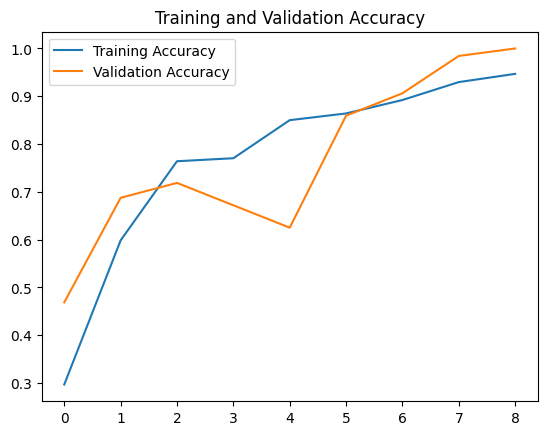

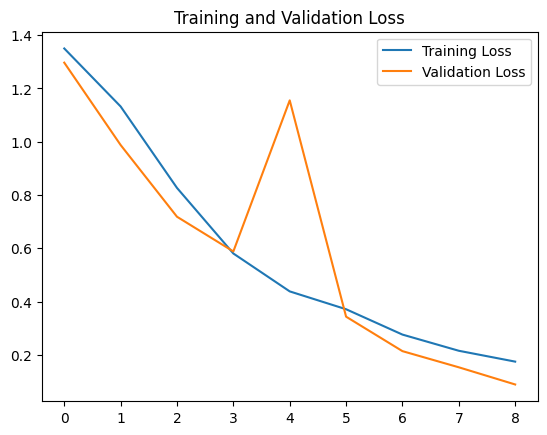

In [41]:
acc = hist['accuracy']
val_acc = hist['val_accuracy']

loss = hist['loss']
val_loss = hist['val_loss']

epochs_range = range(EPOCHS)

plt.figure()
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Training and Validation Accuracy')

plt.figure()
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.title('Training and Validation Loss')
plt.show()

In [42]:
pre=tf.keras.metrics.Precision()
re=tf.keras.metrics.Recall()
acc=tf.keras.metrics.Accuracy()

for index,batch in enumerate(test.as_numpy_iterator()): 
    X, y = batch
    yhat_model = model.predict(X)
    yhat=np.argmax(yhat_model, axis=1)
    yhat_pred=np.max(yhat_model,axis=1)
    print(y)
    print(yhat)
    print(yhat_pred)
    pre.update_state(y,yhat)
    re.update_state(y,yhat)
    acc.update_state(y,yhat)

precision=pre.result().numpy()
recall=re.result().numpy()
accuracy=acc.result().numpy()
F1Score = 2 * (precision * recall) / (precision + recall)

print(f'metrics in batch {index}')
print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'F1Score : {F1Score}')

1/1 [==============================] - 0s 265ms/step
[2 1 2 2 3 3 0 3 0 2 3 1 0 3 0 2 1 1 1 2 2 0 3 0 3 0 0 1 0 3 1 3]
[2 1 2 2 3 3 0 3 0 2 3 1 0 3 0 2 1 1 1 2 2 0 3 0 3 0 0 1 0 3 1 3]
[0.98810583 0.9843078  0.9951172  0.9879198  0.86394536 0.77065444
 0.91154826 0.74800485 0.74357885 0.98704433 0.86116    0.99759287
 0.95080966 0.96377516 0.53536564 0.98083824 0.9914357  0.9980065
 0.99876803 0.9660363  0.9937106  0.9601288  0.9513615  0.90088624
 0.9732464  0.8617938  0.80077237 0.99875367 0.84735364 0.96970195
 0.99592036 0.8977353 ]
1/1 [==============================] - 0s 221ms/step
[3 1 3 1 1 1 2 0 1 1 2 0 0 1 3 2 0 0 3 3 3 2 3 0 2 2 3 1 1 1 3 2]
[3 1 3 1 1 1 2 0 1 1 2 0 0 1 3 2 0 0 3 3 3 2 3 0 2 2 3 1 1 1 3 2]
[0.79667956 0.99771494 0.91315174 0.99659455 0.99737805 0.9962063
 0.96019006 0.9449215  0.9987494  0.99492216 0.97798467 0.9594253
 0.76365453 0.9866848  0.9226052  0.9779103  0.4581634  0.9151152
 0.8808847  0.8938785  0.83490986 0.96630865 0.69422305 0.82126117
 0.9854

In [45]:
mistaken=0

for _ in range(100):
    random_class=random.choice(CLASSES)
    random_path=os.path.join(DATA_PATH,random_class)
    random_image=random.choice(os.listdir(random_path))
    img=cv2.imread(os.path.join(random_path,random_image))
    #print(img.shape)
    if img.shape!=(IMG_WIDTH,IMG_HEIGHT,RGB):
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT), interpolation = cv2.INTER_AREA)
    ans=model.predict(np.expand_dims(img/255,0))
    true_label=random_class
    pred_label=CLASSES[ans.argmax()]
#     plt.figure()
#     plt.title(f"True label: {true_label}, Pred label: {pred_label}")
#     plt.imshow(img)
    if (true_label != pred_label): mistaken+=1
print(mistaken)
# plt.show()

1/1 [==============================] - 0s 27ms/step
5
